# Sentiment Analysis on Amazon Reviews
## Done by: Slamova Gaukhar, Samoilova Malika, Nurbekova Tamiris

In [1]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bz2
import sys
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#NLTK
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.stem.porter import PorterStemmer
#Additional
import gc #Garbage collection
import re #Regular expressions

In [2]:
from google.colab import drive # 4/1AY0e-g5RuZNwBIL1TxvearhnQDywjbF9kHwrEW5NXjoBvWUQ7DFIE2XiWnc
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [4]:
#Getting data from the bz2 file 
train_file = bz2.BZ2File('train.ft.txt.bz2')
test_file = bz2.BZ2File('test.ft.txt.bz2')

In [5]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [6]:
print(len(train_file_lines))
print(len(test_file_lines))

3600000
400000


In [7]:
del train_file, test_file

In [8]:
#Decode data to utf-8(convert from raw binary strings to strings that can be parsed)
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [9]:
#Extracting labels and texts from the data
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])

#Create DataFrame
train_data = pd.DataFrame({'reviews':train_sentences})
test_data = pd.DataFrame({'reviews':test_sentences})
train_data['labels'] = train_labels
test_data['labels'] = test_labels

In [10]:
del train_file_lines, test_file_lines

In [11]:
#Garbage collection
gc.collect()

111

In [12]:
train_data_df = train_data.append(test_data)
display(train_data_df)

,reviews,labels
0,stuning even for the non-gamer: this sound tra...,1
1,the best soundtrack ever to anything.: i'm rea...,1
2,amazing!: this soundtrack is my favorite music...,1
3,excellent soundtrack: i truly like this soundt...,1
4,"remember, pull your jaw off the floor after he...",1
...,...,...
399995,unbelievable- in a bad way: we bought this tho...,0
399996,"almost great, until it broke...: my son reciev...",0
399997,disappointed !!!: i bought this toy for my son...,0
399998,classic jessica mitford: this is a compilation...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Train Labels distribution')

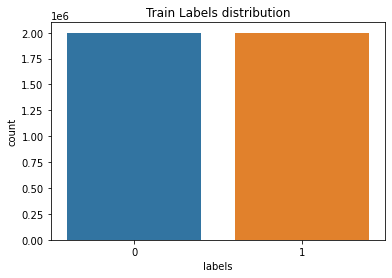

In [13]:
sns.countplot(train_data_df['labels'])
plt.title('Train Labels distribution')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Word Frequency Distribution in Reviews')

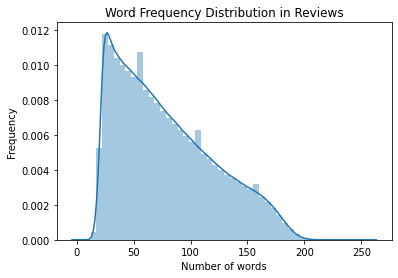

In [14]:
#Word Frequency Distribution in Reviews
train_sentences_size = list(map(lambda x: len(x.split()), train_data_df['reviews']))

sns.distplot(train_sentences_size)
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution in Reviews")

In [15]:
train_label_len = pd.DataFrame({"labels": train_data_df['labels'], "len": train_sentences_size})
train_label_len.head()

,labels,len
0,1,80
1,1,97
2,1,129
3,1,118
4,1,87


Negative mean length: 81.49
Positive mean length: 75.46
Mean Difference: 6.03


Text(0.5, 1.0, 'Review Size Categorization')

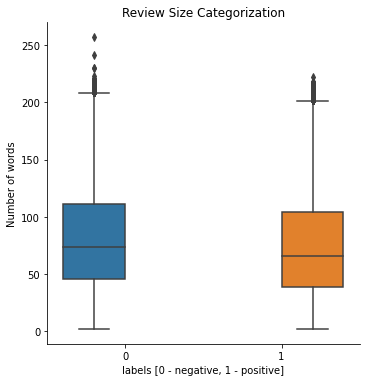

In [16]:
# calculate average values of sentiments
neg_mean_len = train_label_len.groupby('labels')['len'].mean().values[0]
pos_mean_len = train_label_len.groupby('labels')['len'].mean().values[1]
#0->negative, 1->positive
print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
sns.catplot(x='labels', y='len', data=train_label_len, kind='box', hue="labels")
plt.xlabel("labels [0 - negative, 1 - positive]")
plt.ylabel("Number of words")
plt.title("Review Size Categorization")

In [17]:
del neg_mean_len,pos_mean_len
gc.collect()

125

## Data Preprocessing

In [18]:
train_data_df['reviews'].head()

0    stuning even for the non-gamer: this sound tra...
1    the best soundtrack ever to anything.: i'm rea...
2    amazing!: this soundtrack is my favorite music...
3    excellent soundtrack: i truly like this soundt...
4    remember, pull your jaw off the floor after he...
Name: reviews, dtype: object

In [19]:
def preprocess_word(word):
    word = word.strip('\'"?!,.():;')  # Remove punctuation
    word = re.sub(r'(.)\1+', r'\1\1', word)# Convert more than 2 letter repetitions to 2 letter funnnnny --> funny
    word = re.sub(r'(-|\')', '', word)# Remove - & '
    return word

def is_valid_word(word):
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)# Check if word begins with an alphabet

def handle_emojis(review):
    review = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' emo_pos ', review)    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    review = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' emo_pos ', review) # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    review = re.sub(r'(<3|:\*)', ' emo_pos ', review)  # Love -- <3, :*
    review = re.sub(r'(;-?\)|;-?D|\(-?;)', ' emo_pos ', review) # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    review = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' emo_neg ', review)# Sad -- :-(, : (, :(, ):, )-:
    review = re.sub(r'(:,\(|:\'\(|:"\()', ' emo_neg ', review)# Cry -- :,(, :'(, :"(
    return review

def preprocess_review(review):
    processed_review = []
    review = review.lower()# Convert to lower case
    review = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' url ', review)# Replaces url with the word url
    review = re.sub(r'@[\S]+', 'user_mention', review)# Replace @handle with the word USER_MENTION
    review = re.sub(r'#(\S+)', r' \1 ', review)# Replaces #hashtag with hashtag
    review = re.sub(r'\brt\b', '', review)# Remove RR (rereview)
    review = re.sub(r'\.{2,}', ' ', review) # Replace 2+ dots with space
    review = review.strip(' "\'') # Strip space, " and ' from review
    review = handle_emojis(review)# Replace emojis with either EMO_POS or EMO_NEG
    review = re.sub(r'\s+', ' ', review)# Replace multiple spaces with a single space
    words = review.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            if use_stemmer:
                word = str(porter_stemmer.stem(word))
            processed_review.append(word)

    return ' '.join(processed_review)

if __name__ == '__main__':
    use_stemmer = False
    if use_stemmer:
        porter_stemmer = PorterStemmer() # use Porter Stemmer
    train_data_df['reviews'] = train_data_df['reviews'].apply(lambda x: preprocess_review(x))

In [20]:
# Import Drive API and authenticate.
#from google.colab import drive

# Mount your Drive to the Colab VM.
#drive.mount('/content/drive')

# Write the DataFrame to CSV file.
#with open('/gdrive/My Drive/Colab\ Notebooks/train_data_cleaned.csv', 'w') as f:
# train_data_df.to_csv(f)
# train_data_df.to_csv('/content/drive/My\ Drive/Colab\ Notebooks/train_data_cleaned.csv')
#train_data_df.to_csv ('train_data_cleaned.csv', index = False, header=True)

In [21]:
# Write the DataFrame to CSV file.
#train_data_df.to_csv('/content/drive/My\ Drive/train_data_cleaned.csv')
from google.colab import files
train_data_df.to_csv('train_data_cleaned.csv') 
files.download('train_data_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
train_data_df['reviews'].head()
gc.collect()

150

In [23]:
gc.collect()
train_data_df = pd.read_csv('train_data_cleaned.csv') 

In [24]:
type(train_data_df['reviews'])

pandas.core.series.Series

In [29]:
import nltk
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

In [30]:
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [33]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
        
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

In [40]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords_nltk_en = set(stopwords.words('english'))

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return [word for word in lemmatize_sent(text) 
            if word not in stopwords_nltk_en
            and not word.isdigit()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Word Embeddings

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=preprocess_text)

In [42]:
train_set = count_vect.fit_transform(train_data_df['reviews'][:10000])

In [43]:
train_set.toarray().shape

(10000, 30813)

In [48]:
test_set = count_vect.transform(train_data_df['reviews'][:1000])

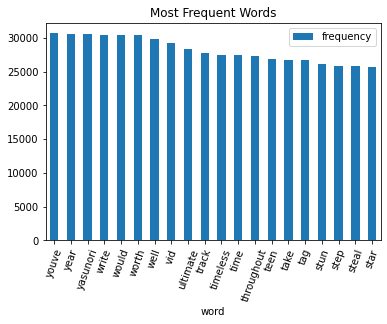

In [45]:
most_freq_words = pd.DataFrame(count_vect.vocabulary_.items(), columns=['word', 'frequency'])[:100].sort_values(ascending=False, by = "frequency")[:20]
most_freq_words.plot.bar(x="word", y="frequency", rot=70, title="Most Frequent Words")

In [46]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
clf.fit(train_set, train_data_df['labels'][:10000])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# To predict our tags, we feed the vectorized `test_set` to .predict()
predictions_valid = clf.predict(test_set)

print('Amazon Sentiment Analysis Accuracy = {}'.format(accuracy_score(predictions_valid, train_data_df['labels'][:1000]) * 100))
print("Confusion Matrix: ")
print(confusion_matrix(predictions_valid, train_data_df['labels'][:1000]))
print("Classification report: ")
print(classification_report(predictions_valid, train_data_df['labels'][:1000], target_names=['negative','positive']))

Amazon Sentiment Analysis Accuracy = 93.30000000000001
Confusion Matrix: 
[[510  39]
 [ 28 423]]
Classification report: 
              precision    recall  f1-score   support

    negative       0.95      0.93      0.94       549
    positive       0.92      0.94      0.93       451

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [61]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10, 100]}
svc = svm.SVC()
clf2 = GridSearchCV(svc, parameters)
clf2.fit(train_set, train_data_df['labels'][:10000])
sorted(clf2.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [62]:
# To predict our tags, we feed the vectorized `test_set` to .predict()
predictions_valid2 = clf2.predict(test_set)

print('Amazon Sentiment Analysis Accuracy on SVM = {}'.format(accuracy_score(predictions_valid2, train_data_df['labels'][:1000]) * 100))
print("Confusion Matrix: ")
print(confusion_matrix(predictions_valid2, train_data_df['labels'][:1000]))
print("Classification report: ")
print(classification_report(predictions_valid2, train_data_df['labels'][:1000], target_names=['negative','positive']))

Amazon Sentiment Analysis Accuracy on SVM = 91.0
Confusion Matrix: 
[[484  36]
 [ 54 426]]
Classification report: 
              precision    recall  f1-score   support

    negative       0.90      0.93      0.91       520
    positive       0.92      0.89      0.90       480

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

